In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pprint

import clu.checkpoint
import jax
import jax.numpy as jnp
import sqlalchemy as sa
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, diffusion, sde_diffusion, utils

2025-01-07 00:00:51.318204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736208051.335859   39406 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736208051.341243   39406 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Diffusion Models
config_alt_id = '3sixjrsv'  # c = 4
# config_alt_id = 'set411t3'  # c = 8
# config_alt_id = 'ms7z95cb'  # c = 16
# config_alt_id = '59hltmbb'  # c = 32
# config_alt_id = 'jnn1i02w'  # c = 64

# Flow Matching
# config_alt_id = '7wr0gvt1'  # c = 4
# config_alt_id = ''  # c = 8
# config_alt_id = ''  # c = 16
# config_alt_id = ''  # c = 32
# config_alt_id = ''  # c = 64

In [3]:
engine = cs.get_engine()
cs.create_all(engine)
with cs.orm.Session(engine) as session:
    cfg = session.execute(sa.select(cs.Config).where(cs.Config.alt_id == config_alt_id)).first()[0]
    # cfg_model = cs.detach_config_from_session(type(cfg.model), cfg.model.id, session)
    pprint.pp(cfg)

    key = jax.random.key(cfg.rng_seed)
    key, key_dataset = jax.random.split(key)
    
    ds = datasets.get_dataset(cfg.dataset, key=key_dataset)

    cfg_unet = unet.unet_64_config(
        ds.Zs.shape[-1],
        base_channels=cfg.model.architecture.base_channel_count,
        attention=cfg.model.architecture.attention,
    )
    model = unet.UNet(cfg_unet)
    # just create params, restore saved weights later
    params = model.init(
        jax.random.key(0),
        x=ds.Zs[:cfg.dataset.batch_size],
        t=jnp.zeros(cfg.dataset.batch_size),
        train=False,
        cond=None,
    )
    ckpt = clu.checkpoint.MultihostCheckpoint(str(cfg.run_dir/'model-checkpoints'), {}, max_to_keep=2)
    ema_params = ckpt.restore(params)

Config(root_dir='/root/workspace/GitHub/pmlr-v202-finzi23a',
       src_dir='/root/workspace/GitHub/pmlr-v202-finzi23a/userdiffusion/src',
       out_dir='/root/workspace/out/diffusion-dynamics/pmlr-v202-finzi23a',
       prediction_filename='prediction.pt',
       device='cuda',
       id=9,
       alt_id='3sixjrsv',
       rng_seed=42,
       fit=True,
       predict=False,
       model=ModelDiffusion(id=4,
                            architecture=UNet(id=2,
                                              epochs=10000,
                                              learning_rate=0.0001,
                                              base_channel_count=4,
                                              attention=False),
                            sde_diffusion=SDEVarianceExploding(id=1,
                                                               time_min=0.001,
                                                               time_max=1.0,
                                                  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.53it/s]
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/jax/_src/numpy/linalg.py:1343: FutureWarning: jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, and in the future will be treated as a batched 2D solve. Use solve(a, b[..., None])[..., 0] to avoid this warning.
  warnings.warn("jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, "
I0000 00:00:1736208080.145645   39406 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4229 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6


In [4]:
ds.Zs[:cfg.dataset.batch_size].shape

(500, 60, 2)

In [5]:
data_std = ds.Zs[cfg.dataset.batch_size:].std()
data_std

Array(1.0257994, dtype=float32)

In [6]:
@jax.jit
def score(x, t, cond=None):
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return diffusion.score(model, ema_params, difftype, data_std, x, t, train=False, cond=cond)

In [7]:
@jax.jit
def velocity(x, t, cond=None):
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return model.apply(ema_params, x=x, t=t, train=False, cond=cond)

In [8]:
trajectory_count = 10
key, key_samples = jax.random.split(key)
if isinstance(cfg.model, cs.ModelDiffusion):
    difftype = sde_diffusion.get_sde_diffusion(cfg.model.sde_diffusion)
    samples = samplers.sde_sample(difftype, score, key_samples, x_shape=ds.Zs[:trajectory_count].shape, nsteps=1_000)
elif isinstance(cfg.model, cs.ModelFlowMatching):
    samples = samplers.ode_sample_taos(velocity, 1., key_samples, x_shape=ds.Zs[:trajectory_count].shape, nsteps=1_000)
else:
    raise ValueError(f'Unknown model: {cfg.model}')

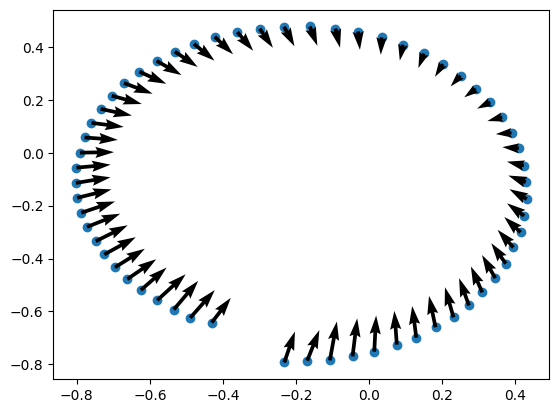

In [9]:
pos = jax.random.normal(jax.random.key(0), ds.Zs[:1].shape)
pos = samples[:1]
vel = velocity(pos, 1.)[0]
fig, ax = plt.subplots()
pos = pos.squeeze(0)
ax.scatter(pos[:, 0], pos[:, 1])
ax.quiver(pos[:, 0], pos[:, 1], vel[:, 0], vel[:, 1])

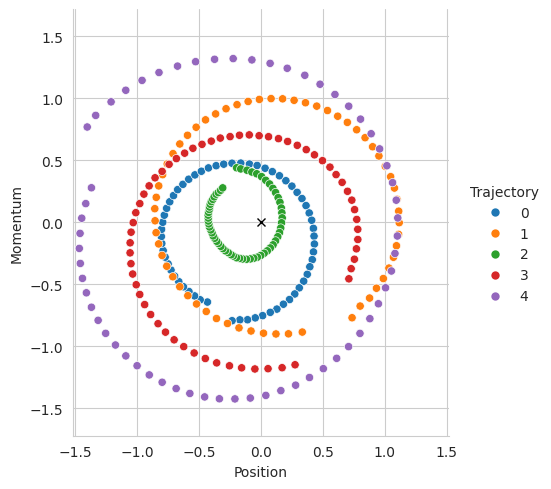

In [10]:
df = pd.concat([
    pd.DataFrame(dict(
        Trajectory=str(i), Position=samples[i, :, 0], Momentum=samples[i, :, 1]
    ))
    for i in range(5)
])
df = df.reset_index(names='Time Step')
sns.set_style('whitegrid')
plot = sns.relplot(
    data=df,
    x='Position', y='Momentum',
    hue='Trajectory',
    height=5, aspect=1,
)
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    xmax, ymax = data[['Position', 'Momentum']].max(axis=0) + .4
    ax.set_xlim(xmin=-xmax, xmax=xmax)
    ax.set_ylim(ymin=-ymax, ymax=ymax)
    ax.set_aspect('equal')
    ax.plot([0], [0], 'kx')

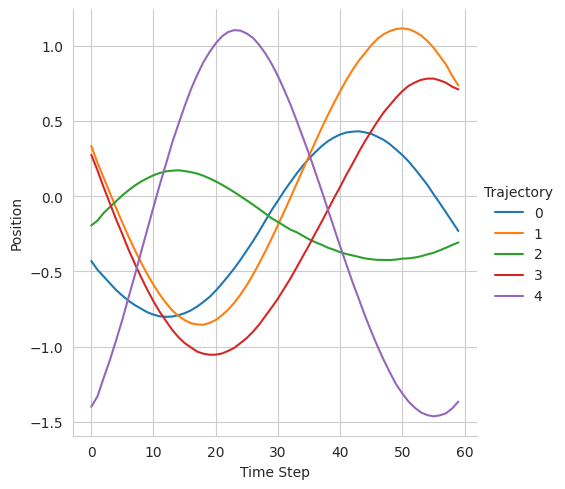

In [11]:
sns.relplot(kind='line', data=df, x='Time Step', y='Position', hue='Trajectory')